In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*`torch.cuda.amp.autocast.*")
import torch
import numpy as np
import random
import PIL.Image
import matplotlib.pyplot as plt
from types import SimpleNamespace
from datasets import load_dataset
from timm.optim import Mars
from torchvision.transforms.v2 import (
    Compose, Resize, RandomCrop, CenterCrop,
    PILToTensor, ToPILImage, CutMix )
from fastprogress.fastprogress import master_bar, progress_bar
from IPython.display import display, HTML

In [2]:
torch.set_float32_matmul_precision('high')
device = "cuda:5"
dataset_train = load_dataset('danjacobellis/bloodmnist_224',split='train')
dataset_valid = load_dataset('danjacobellis/bloodmnist_224',split='validation')

In [3]:
config = SimpleNamespace()
# Training and optimizer config
config.batch_size = 128
config.steps_per_epoch = dataset_train.num_rows//config.batch_size
config.grad_accum_steps = 1
config.max_lr = (config.batch_size/128)*6e-4
config.min_lr = config.max_lr/100
config.plot_update = 64
config.epochs = 200
config.lr_scale = 40
config.lr_offset = 0.25
config.lr_pow = 6
config.weight_decay = 0.
config.num_workers = 12
config.image_size = 272
config.crop_size = 256

# model config
config.channels = 3
config.J = 4
config.embed_dim = 512
config.dim_head = 64
config.classifier_num_classes = 8
config.checkpoint = False

In [4]:
from pytorch_wavelets import DWTForward
from tft.transforms import WPT2D
from tft.models import TFTClassifier

wt = DWTForward(J=1, mode='periodization', wave='bior4.4')
wpt = WPT2D(wt).to(device)
model = TFTClassifier(config,wpt).to(device)

for name, module in model.named_children():
    print(f"{sum(p.numel() for p in module.parameters())/1e6} \t {name}")

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint, map_location="cpu", weights_only=False)
    model.load_state_dict(checkpoint['model'])

0.0 	 wpt
24.974848 	 ascan
0.306176 	 pool
0.004104 	 classifier


In [5]:
cutmix_transform = CutMix(num_classes=config.classifier_num_classes, alpha=1.)
rand_crop = Compose([
    Resize(size=config.image_size,interpolation=PIL.Image.Resampling.LANCZOS),
    RandomCrop(size=config.crop_size),
    PILToTensor()
])
cent_crop = Compose([
    Resize(size=config.image_size,interpolation=PIL.Image.Resampling.LANCZOS),
    CenterCrop(size=config.crop_size),
    PILToTensor()
])
def train_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, config.crop_size, config.crop_size), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['label'][0]
        x[i_sample,:,:,:] = rand_crop(sample['image'])
    return x, y

def valid_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, config.crop_size, config.crop_size), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['label'][0]
        x[i_sample,:,:,:] = cent_crop(sample['image'])
    return (x,y)

In [6]:
optimizer = Mars(
    params=model.parameters(),
    lr=config.min_lr,
    weight_decay=config.weight_decay,
    caution=True
)

import numpy as np

def EmPL(x):
    return np.exp(-np.power(np.log(x), config.lr_pow))
        
def EmPL_sched(i_step, config):
    x = i_step / (config.steps_per_epoch/config.plot_update)
    sched = EmPL(x/(config.lr_scale*config.steps_per_epoch/config.plot_update)+config.lr_offset)
    scale = config.max_lr
    lr = scale * sched
    return lr / config.min_lr
    
schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: EmPL_sched(i_step, config),
)

/home/dgj335/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


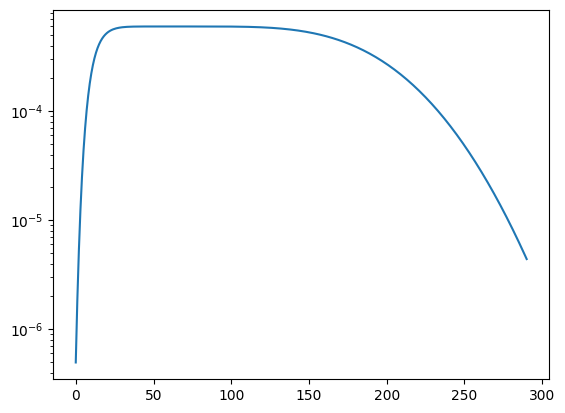

In [7]:
# learning_rates = [optimizer.param_groups[0]['lr']]
# i_step = 0
# for i_epoch in range(config.epochs):
#     for i_batch in range(config.steps_per_epoch):
#         if (i_step+1) % config.plot_update == 0:
#             schedule.step()
#             learning_rates.append(optimizer.param_groups[0]['lr'])
#         i_step+=1
# import matplotlib.pyplot as plt
# plt.semilogy(learning_rates)

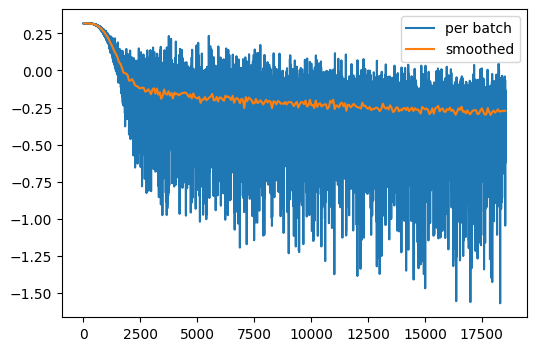

In [7]:
mb = master_bar(range(config.epochs))
mb.names = ['per batch','smoothed']
train_loss = []
valid_acc = []
learning_rates = [optimizer.param_groups[0]['lr']]
i_step = 0
for i_epoch in mb:
    # training
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=train_collate_fn
    )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, (x,y) in enumerate(pb):
        y = y.to(torch.long).to(device)
        x = x.to(device).to(torch.float)/255
        x, y = cutmix_transform(x, y)

        logits = model(x-0.5)
        loss = torch.nn.CrossEntropyLoss()(input=logits, target=y)

        train_loss.append(loss.item())
        loss.backward()
        if (i_batch + 1) % config.grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # plotting and learning rate update
        if (i_step+1) % config.plot_update == 0:
            plot_n = len(train_loss) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(train_loss).reshape(plot_n, -1).mean(dim=1)
            train_x = range(len(train_loss))
            train_y = train_loss
            mb.update_graph([[train_x, np.log10(train_y)],[smoothed_x, np.log10(smoothed_y)]])

            # lr update
            schedule.step()
            learning_rates.append(optimizer.param_groups[0]['lr'])
    
        i_step+=1
        
    # validation
    model.eval()
    valid_acc.append(0)
    data_loader_valid = torch.utils.data.DataLoader(
        dataset_valid,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=False,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )
    pb_valid = progress_bar(data_loader_valid, parent=mb)
    for i_batch, (x, y) in enumerate(pb_valid):
        y = y.to(torch.long).to(device)
        x = x.to(device).to(torch.float)/255
        with torch.no_grad():
            logits = model(x-0.5)
        valid_acc[i_epoch] += torch.sum(logits.argmax(dim=1) == y).item()
    valid_acc[i_epoch] /= len(dataset_valid)
    
    mb.main_bar.comment = f'valid_acc {valid_acc[i_epoch]:.4g}'
    
    torch.save({
        'i_epoch': i_epoch,
        'learning_rates': learning_rates,
        'smoothed_y': smoothed_y,
        'valid_acc': valid_acc,
        'config': config,
        'model_state_dict': model.state_dict(),
    }, f"log_{device}.pth")

In [8]:
from IPython.display import display, Image, update_display, HTML
import matplotlib.pyplot as plt
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

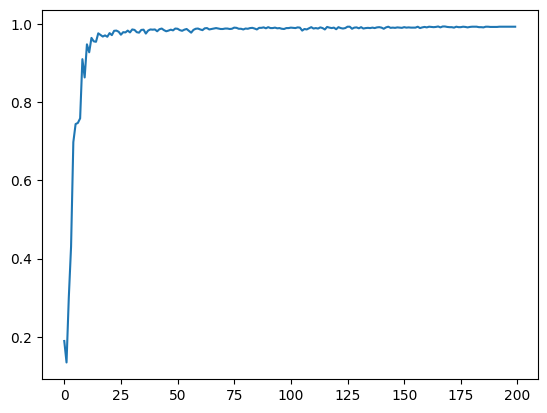

In [9]:
plt.plot(valid_acc)

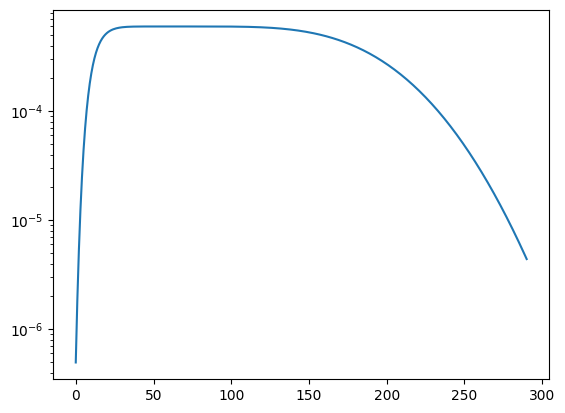

In [10]:
plt.semilogy(learning_rates)

/tmp/ipykernel_1199032/2013070528.py:2: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,2])


(0.4669725561353654, 2)

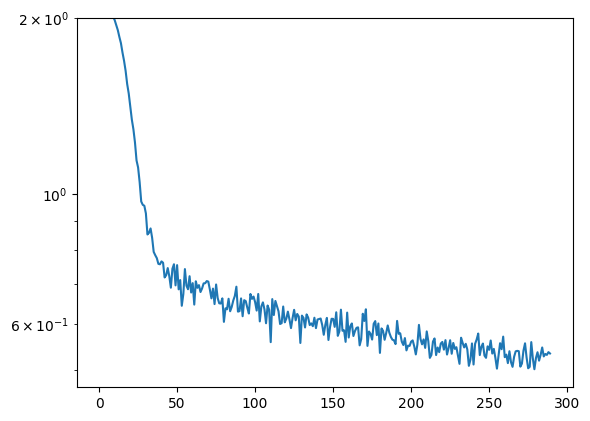

In [12]:
plt.semilogy(smoothed_y)
plt.ylim([0,2])

In [13]:
torch.save({
    'i_epoch': i_epoch,
    'learning_rates': learning_rates,
    'smoothed_y': smoothed_y,
    'valid_acc': valid_acc,
    'config': config,
    'model': model.state_dict(),
}, f"../../hf/tft/bloodmnist_v0.1.pth")